# AWS Zarr Open Registry Data Test

**Goal**
<br/>
To open the MUR 1-km dataset stored in the Amazon Web Services (AWS) Registry of Open Data in conjunction with the MUR Climatology dataset (created by Mike Chin and cleaned in the notebook 'CleaningMURClimatologyData.ipynb') to create a Sea Surface Temperature (SST) anomaly dataset for use in testing runtimes on dataset loading and plotting applications. 

**Run Location**
<br/>
This notebook was run on an AWS EC2 t3.medium instance. It was also successfully run on a t3.small instance.

**Dataset**
<br/>
MUR 1-km L4 SST Zarr https://registry.opendata.aws/mur/

### Import Modules

In [1]:
%matplotlib inline
import s3fs
import numpy as np
import xarray as xr
import fsspec
import zarr
import timeit
import matplotlib.pyplot as plt
from dask.distributed import Client, performance_report

### Dataset URL
<br/>
We use this URL to reference the MUR 1-km L4 dataset on the AWS Open Registry.

In [2]:
URL = 's3://mur-sst/zarr'

## Setup for Regional Tests

### Period and Region of Interest

In [3]:
start_date = "2019-08-01"
end_date = "2020-1-20"

minlat = 18
maxlat = 23
minlon = -160
maxlon = -154

### Open MUR Dataset
<br/>
Open the remote dataset from its S3 endpoint. The dataset is pre-consolidated, meaning the metadata is stored in a single, optimized resource. We can take advantage of this by declaring 'consolidated=True' which uses that resource to reduce the number of read operations when opening the data.

In [4]:
start_time = timeit.default_timer()


mur_global = xr.open_zarr(
    fsspec.get_mapper(URL, anon=True), 
    consolidated=True,
    drop_variables=['sea_ice_fraction', 'analysis_error']
)

mur_hawaii = mur_global.sel(
    time=slice(start_date, end_date),
    lat=slice(minlat, maxlat),
    lon=slice(minlon, maxlon),
).chunk({"time": 30, "lat": 100, "lon": 100})

# mur_hawaii.load()   # Uncomment if you want to load the dataset into memory now


elapsed = timeit.default_timer() - start_time
print(elapsed)

3.4745000289999552


In [5]:
mur_hawaii

<xarray.Dataset>
Dimensions:       (time: 173, lat: 501, lon: 601)
Coordinates:
  * lat           (lat) float32 18.0 18.01 18.02 18.03 ... 22.98 22.99 23.0
  * lon           (lon) float32 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * time          (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(30, 100, 100), meta=np.ndarray>
    mask          (time, lat, lon) int8 dask.array<chunksize=(30, 100, 100), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

### Add in NAN Values for Land to MUR Data
<br/>
We use the mask dimension to replace temperature values from land observations with NaN so that they are not factored in to our calculations. The mask variable has a value for each coordinate pair representing which surface the temperature was collected from (land, open-sea, ice, etc.).

In [6]:
mur_hawaii_sst = mur_hawaii['analysed_sst'].where(mur_hawaii.mask == 1)

### Convert Temperatures to Celsius
<br/>
The dataset is stored with temperatures measured in Kelvin. This converts it to Celsius for ease of understanding and analysis.

In [7]:
mur_hawaii_sst = mur_hawaii_sst - 273.15

In [8]:
mur_hawaii_sst

<xarray.DataArray 'analysed_sst' (time: 173, lat: 501, lon: 601)>
dask.array<sub, shape=(173, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00

### Open MUR Climatology for Hawaii

In [9]:
mur_clim = xr.open_dataarray(
    "../data/MURClimatology.nc",
    chunks={"time": 30, "lat": 100, "lon": 100}
)

In [10]:
mur_clim

,Array,Chunk
Bytes,420.39 MiB,1.14 MiB
Shape,"(366, 501, 601)","(30, 100, 100)"
Count,547 Tasks,546 Chunks
Type,float32,numpy.ndarray


### Drop the Leap Day

In [11]:
mur_clim = mur_clim.where(mur_clim["time"] != np.datetime64('2004-02-29T09:00:00', 'ns'), drop=True)

### Create Subset Dataset

In [12]:
mur_clim_jan = mur_clim[0:20]

In [13]:
mur_clim_subset = mur_clim[212:]

In [14]:
mur_clim_subset = xr.concat([mur_clim_subset, mur_clim_jan], dim="time")

In [15]:
mur_clim_subset = mur_clim_subset.assign_coords({"time": mur_hawaii_sst["time"]})

In [16]:
mur_clim_subset

<xarray.DataArray 'sstclim' (time: 173, lat: 501, lon: 601)>
dask.array<concatenate, shape=(173, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

### Create SST Anomaly Dataset

In [17]:
sst_anomaly = mur_hawaii_sst - mur_clim_subset

In [18]:
sst_anomaly

<xarray.DataArray (time: 173, lat: 501, lon: 601)>
dask.array<sub, shape=(173, 501, 601), dtype=float32, chunksize=(27, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00

### Find Daily Average SST Anomaly for Time Series

In [19]:
sst_anomaly_mean_ts = sst_anomaly.mean(['lat', 'lon'])

In [20]:
sst_anomaly_mean_ts

<xarray.DataArray (time: 173)>
dask.array<mean_agg-aggregate, shape=(173,), dtype=float32, chunksize=(27,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00

### Find Average SST Anomaly for Each Coordinate Pair for Spatial Plot

In [21]:
sst_anomaly_mean_sp = sst_anomaly.mean(['time'])

In [22]:
sst_anomaly_mean_sp

<xarray.DataArray (lat: 501, lon: 601)>
dask.array<mean_agg-aggregate, shape=(501, 601), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0

## Regional Tests

### Regional SST Anomaly Averaged Time Series, August 1st, 2019 - January 20th, 2020

68.67778475499972


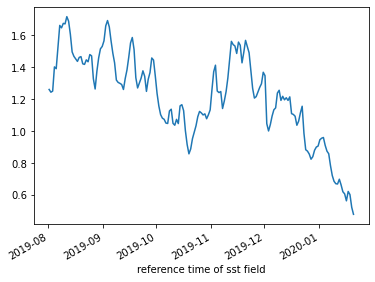

In [23]:
start_time = timeit.default_timer()

sst_anomaly_mean_ts.plot()

elapsed = timeit.default_timer() - start_time
print(elapsed)

### Regional SST Anomaly Averaged Spatial Plot, August 1st, 2019 - January 20th, 2020

/home/ec2-user/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


48.39507011200021


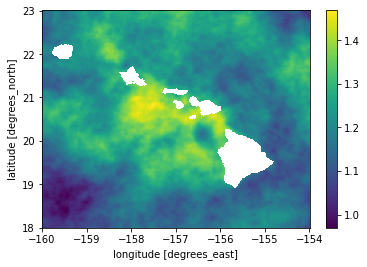

In [24]:
start_time = timeit.default_timer()

sst_anomaly_mean_sp.plot()

elapsed = timeit.default_timer() - start_time
print(elapsed)